> IDEAS
- 맵을 저장하는 데이터 형태를 어떻게 할 것인가? 
 - x, y쌍을 맵으로 놓고 사잇값에 대해서는 내적으로 계산하는 접근
 - piecewise linear형태로 구간별 선형 모형 설계
- 오차를 줄이는 방법은? 
 - 오차분석 필요
 - polynomial regression의 오차 특성은? 양 극단에서 오차가 커지는 이유는? 이를 커버하는 방법은?
- chart는 어떤걸 그리나? 
 - 잔차 plot(time-step)
 - 잔차 크기에 따른 빈도
 - U, W, V - timestep plot
 - p104, X크기에 따른 잔차 plot


> TODO
- 우선 맵 및 공식 전달

###### preparing input data

In [1]:
import os
import numpy as np

os.getcwd()
os.chdir(r'C:\My\x2\180801')
os.getcwd()

file_name = '180801-800~0~800A DATA(UVW상)1.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)3.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)4.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)5.xlsx'
sheet_name = 'Sheet1'

cell_range_list = [('B' + str(5+i*23), 'F' + str(5+i*23+19)) for i in range(17)] + \
[('J' + str(5+i*23), 'N' + str(5+i*23+19)) for i in range(17)]

In [2]:
def load_cells(file_name: str, sheet_name: str, cell_range: tuple):
    from openpyxl import load_workbook
    import pandas as pd

    wb = load_workbook(filename=file_name, read_only=True)
    ws = wb[sheet_name]

    # Read the cell values into a list of lists
    data_rows = []
    for row in ws[cell_range[0]:cell_range[1]]:
        data_cols = []
        for cell in row:
            data_cols.append(cell.value)
        data_rows.append(data_cols)

    # Transform into dataframe
    
    df = pd.DataFrame(data_rows)
    df.columns = ['reg_date', 'G', 'U', 'V', 'W']
    return df

In [3]:
def load_cells_many(file_name: str, sheet_name: str, cell_range_list: list):
    import pandas as pd
    
    df_list = []
    for cell_range in cell_range_list:
        df_list.append(load_cells(file_name, sheet_name, cell_range))
        
    return pd.concat(df_list, ignore_index=True)

In [4]:
df = load_cells_many(file_name, sheet_name, cell_range_list)
df['Order'] = np.floor(df['G'] * 10)
df = df.sort_values(['Order']).reset_index(drop=True)

###### Tools

In [6]:
from sklearn import metrics
'''
metrics.explained_variance_score
metrics.mean_absolute_error
metrics.mean_squared_error
metrics.mean_squared_log_error
metrics.median_absolute_error
metrics.r2_score
'''

def print_metrics(actual, pred):
    actual = np.array(actual) if isinstance(actual, list) else actual
    pred = np.array(pred) if isinstance(pred, list) else pred

    actual = actual.reshape(-1, 1) if len(actual.shape) == 1 else actual
    pred = pred.reshape(-1, 1) if len(pred.shape) == 1 else pred
    
    evs = metrics.explained_variance_score(actual, pred)
    mse = metrics.mean_squared_error(actual, pred)
    mse_ppm = mse * 1e6 / 800 / 300
    mae = metrics.mean_absolute_error(actual, pred)
    mae_ppm = mae * 1e6 / 800 / 300
    r2 = metrics.r2_score(actual, pred)
    max_abs_err = float(np.max(np.abs(actual - pred)))
    
    print('MSE:     :', mse)
    print('MSE ppm  :', mse_ppm)
    print('MAE:     :', mae)
    print('MAE ppm  :', mae_ppm)
    print('Max er   :', max_abs_err)
    print('EVS:     :', mae)
    print('R2 score :', r2)
    

In [7]:
print_metrics([1, 2, 3], [1.1, 1.9, 3])

MSE:     : 0.006666666666666678
MSE ppm  : 0.02777777777777783
MAE:     : 0.06666666666666672
MAE ppm  : 0.277777777777778
Max er   : 0.10000000000000009
EVS:     : 0.06666666666666672
R2 score : 0.99


### model - poly reg

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


dataset_X = df[['V']]
dataset_y = ((df[['G']] / 5 * 1500) / 400) + 2.5

In [10]:
training_set_X, test_set_X, training_set_y, test_set_y = train_test_split(dataset_X, dataset_y, test_size=0.33, random_state=42, shuffle=True)

###### plot training set

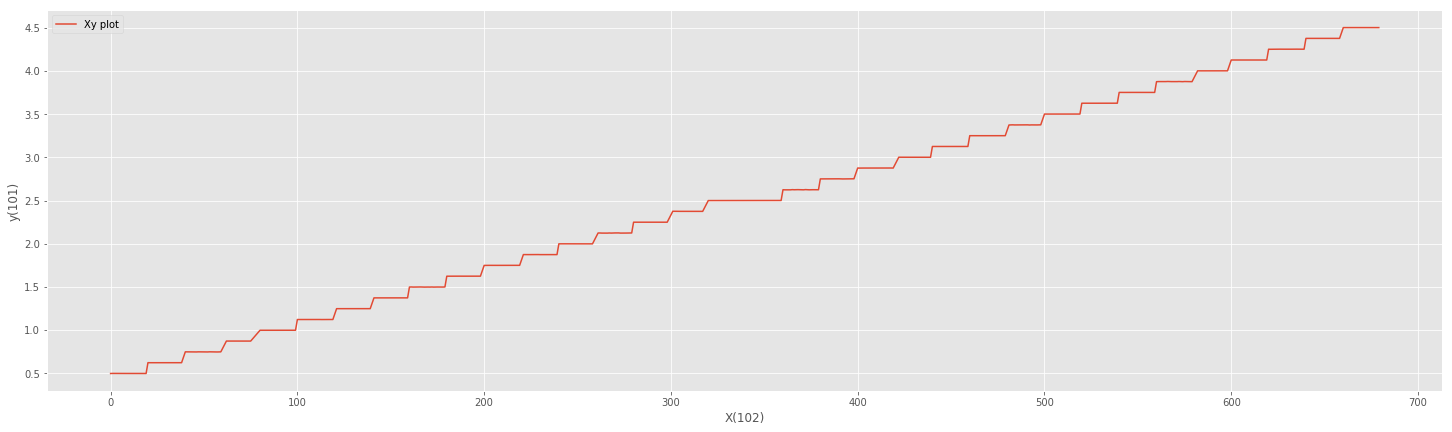

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
# plt_x = range(len(training_set_X))
plt_x = training_set_X.sort_index().index
plt.plot(plt_x, (training_set_y.sort_index()), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


###### Ordinary Least Squares

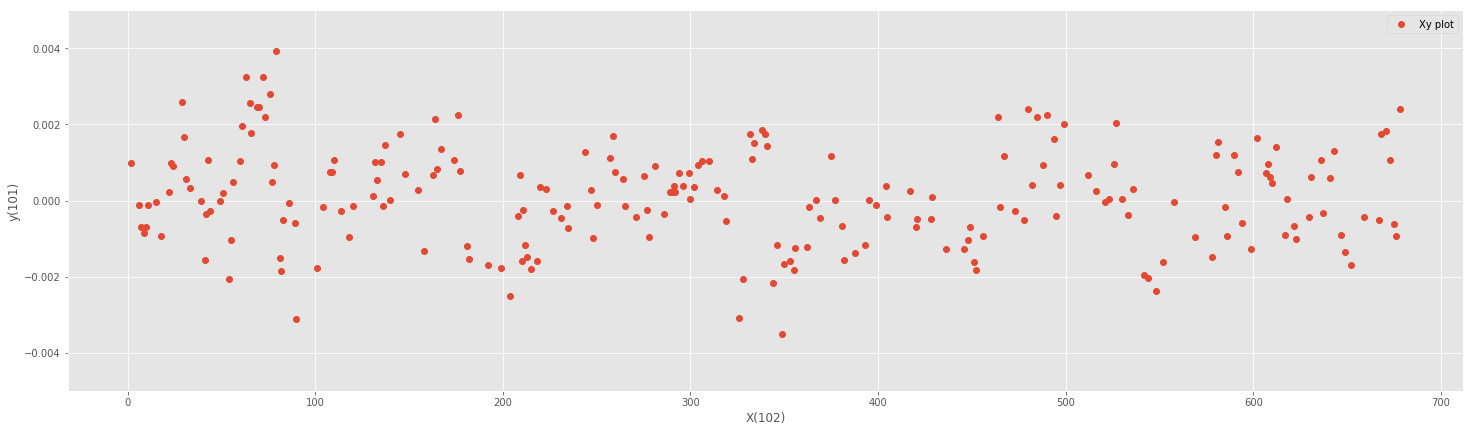

MSE:     : 1.6459878464753548e-06
MSE ppm  : 6.858282693647312e-06
MAE:     : 0.0010207892287095483
MAE ppm  : 0.004253288452956451
Max er   : 0.003919113048102663
EVS:     : 0.0010207892287095483
R2 score : 0.9999988678383216


In [12]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


poly = PolynomialFeatures(degree=10)
training_set_X_poly_reg = poly.fit_transform(training_set_X)
test_set_X_poly_reg = poly.fit_transform(test_set_X.sort_index())  # sorted by index

model_poly_reg = linear_model.LinearRegression(normalize=True)
model_poly_reg.fit(training_set_X_poly_reg, training_set_y)
test_set_pred_poly_reg = model_poly_reg.predict(test_set_X_poly_reg)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=.005, ymin=-.005)
# plt_x = range(len(test_set_X))
plt_x = test_set_X.sort_index().index
plt.plot(plt_x
         , (test_set_y.sort_index() - test_set_pred_poly_reg)
         , label='Xy plot'
         , linestyle='None'
         , marker='o')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()

print_metrics(test_set_y.sort_index(), test_set_pred_poly_reg)

###### plot - test set

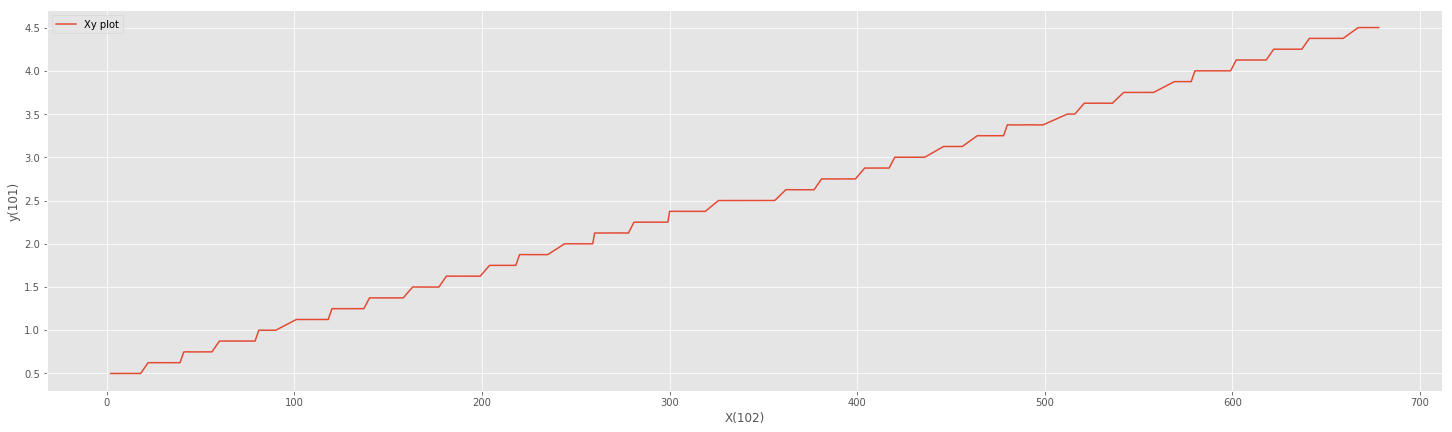

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
# plt_x = range(len(training_set_X))
plt_x = test_set_X.sort_index().index
plt.plot(plt_x, (test_set_y.sort_index()), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


- expected gold error: 1ppm = 800 / 1000000 = 0.0008
- normal silver error: 1% = 800 / 100 = 8

In [14]:
np.min(df['U']), np.max(df['U'])

(0.560389, 4.511796)

### grid

In [15]:
spacing = 0.005

grid_x_start = 0.5
grid_x_end = 4.5 + spacing

In [16]:
# num_slice = 1000
# grid_x_val, spacing = np.linspace(start=grid_x_start, stop=grid_x_end, num=num_slice, endpoint=True, retstep=True)

In [17]:
grid_x_val = np.arange(start=grid_x_start
                   , stop=grid_x_end
                   , step=spacing)

In [21]:
grid_x_val_poly_reg = poly.fit_transform(grid_x_val.reshape(-1, 1))
grid_y_val_poly_reg_pred = model_poly_reg.predict(grid_x_val_poly_reg)

In [22]:
def get_bound(grid_x_val, input_x):
    for i in range(len(grid_x_val)-1):
        if grid_x_val[i] <= input_x and input_x <= grid_x_val[i+1]:
            lower = grid_x_val[i]
            upper = grid_x_val[i+1]
            break      
    interval = upper - lower

    # print(lower ,upper, interval)
    
    ip_b = (upper - input_x) / interval
    ip_a = 1 - ip_b
    return i, i+1, ip_a, ip_b

get_bound(grid_x_val, input_x=3.1211)

(524, 525, 0.21999999999958075, 0.7800000000004192)

In [23]:
def get_bound_fixed_slicing(range_start, range_end, spacing, input_x):
    steps = int((input_x - range_start) / spacing)
    
    lower = steps * spacing
    upper = lower + spacing
    
    interval = spacing
    ip_b = (upper - input_x) / interval
    ip_a = 1 - ip_b
    
    # print(lower, upper, interval)
    
    return steps, steps+1, ip_a, ip_b
    

get_bound_fixed_slicing(grid_x_start, grid_x_end, spacing, 3.1211)

(524, 525, 100.22000000000004, -99.22000000000004)

In [24]:
def grid_inner_pred(input_x, grid_x_val, grid_y):
    
    lower_idx, upper_idx, ip_a, ip_b = get_bound(grid_x_val, input_x)
    lower_y = grid_y[lower_idx]
    upper_y = grid_y[upper_idx]
    
    return lower_y * ip_a + upper_y * ip_b

In [25]:
grid_inner_pred(3, grid_x_val, grid_y_val_poly_reg_pred)

array([2.93285442])

In [26]:
xy = np.concatenate((grid_x_val.reshape(-1, 1), grid_y_val_poly_reg_pred), axis=1)

In [36]:
from datetime import datetime

d = datetime.now()
out_file_name = file_name + '__n' + str(len(grid_x_val)) + '__d' + d.strftime('%Y%m%d%H%M%S') + '.csv'
np.savetxt(out_file_name, xy, delimiter=",")

In [95]:
import os
os.getcwd()

'C:\\My\\Playground\\Github\\pg\\_chaos'

In [81]:
1e20

1e+20